In [26]:
from medAI.datasets import ExactNCT2013BmodeImagesWithAutomaticProstateSegmentation, CohortSelectionOptions
import torch 
import matplotlib.pyplot as plt
from torchvision import transforms as T
T.InterpolationMode.NEAREST
RESNET10_PATH = '/ssd005/projects/exactvu_pca/checkpoint_store/vicreg_resnet10_feature_extractor_fold0.pth'


def transform(item): 
    bmode = item['bmode']
    needle_mask = item['needle_mask']
    grade = item['grade']
    prostate_mask = item['prostate_mask']

    bmode = torch.tensor(bmode).float()[None, ...]
    #bmode = bmode.repeat(3, 1, 1)
    bmode = (bmode - bmode.min()) / (bmode.max() - bmode.min())
    # bmode = T.Resize((1024, 1024), antialias=True)(bmode)
    bmode = bmode.flip(1)

    needle_mask = torch.tensor(needle_mask != 0).float()[None, ...]
    needle_mask = T.Resize((1024, 1024), interpolation=T.InterpolationMode.NEAREST, antialias=False)(needle_mask)
    needle_mask = needle_mask.flip(1)

    prostate_mask = torch.tensor(prostate_mask != 0).float()[None, ...]
    prostate_mask = T.Resize((1024, 1024), interpolation=T.InterpolationMode.NEAREST, antialias=False)(prostate_mask)
    prostate_mask = prostate_mask.flip(1)

    grade = torch.tensor(grade != 'Benign').long()

    return bmode, needle_mask, grade, prostate_mask

cohort_selection_options = CohortSelectionOptions(
    min_involvement=40, benign_to_cancer_ratio=2, remove_benign_from_positive_patients=True,
    fold=0
)
train_ds = ExactNCT2013BmodeImagesWithAutomaticProstateSegmentation(split='train', transform=transform, cohort_selection_options=cohort_selection_options)
test_ds = ExactNCT2013BmodeImagesWithAutomaticProstateSegmentation(split='test', transform=transform, cohort_selection_options=CohortSelectionOptions(fold=0, min_involvement=40, benign_to_cancer_ratio=None))

In [28]:
def transform(item): 
    patch = item['patch']
    grade = item['grade']
    id_ = item['id']
    id_ = torch.tensor(id_).long()

    patch = torch.tensor(patch).float()[None, ...]
    patch = T.Resize((256, 256))(patch)
    patch = (patch - patch.mean()) / patch.std()
    
    label = torch.tensor(grade != 'Benign').long()

    return patch, label, id_

from medAI.datasets import ExactNCT2013BmodePatches
train_ds_patches = ExactNCT2013BmodePatches(split='train', prescale_image=False, transform=transform, cohort_selection_options=cohort_selection_options)
test_ds_patches = ExactNCT2013BmodePatches(split='test', prescale_image=False, transform=transform, cohort_selection_options=CohortSelectionOptions(fold=0, min_involvement=40, benign_to_cancer_ratio=None))

Computing positions: 100%|██████████| 1265/1265 [00:05<00:00, 221.96it/s]


In [29]:
MODE = 'cores'

In [30]:

if MODE == 'patches':
    
    from trusnet.modeling.registry import resnet10_feature_extractor
    from tqdm import tqdm
    model = resnet10_feature_extractor().cuda()
    model.load_state_dict(torch.load(RESNET10_PATH))
    linear_layer = torch.nn.Linear(512, 2).cuda()
    
    class LinearEval(torch.nn.Module):
        def __init__(self, model, linear_layer): 
            super().__init__()
            self.model = model
            self.linear_layer = linear_layer
    
        def forward(self, x):
            with torch.no_grad(): 
                x = self.model(x)
            x = self.linear_layer(x)
            return x
    
        def train(self, mode: bool = True):
            super().train(mode)
            self.model.eval()
    
    
    #model = torch.nn.Sequential(model, linear_layer)
    model = LinearEval(model, linear_layer)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    
    
    def epoch(model, loader, optimizer=None, test=False):
        model.train() if not test else model.eval()
    
        all_prob = []
        all_label = []
        core_idx = []
        for i, batch in enumerate(tqdm(loader)): 
            patch, label, id_ = batch
            patch = patch.cuda()
            label = label.cuda()
            id_ = id_.cuda()
    
            with torch.no_grad() if test else torch.enable_grad(): 
                logits = model(patch)
                loss = torch.nn.functional.cross_entropy(logits, label)
    
            if not test: 
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
    
            all_prob.append(torch.softmax(logits, 1)[:, 1].detach().cpu())
            all_label.append(label.detach().cpu())
            core_idx.append(id_.detach().cpu())
    
        all_prob = torch.cat(all_prob)
        all_label = torch.cat(all_label)
        core_idx = torch.cat(core_idx)
    
        core_prob = []
        core_label = []
        for i in core_idx.unique(): 
            core_prob.append(all_prob[core_idx == i].mean())
            core_label.append(all_label[core_idx == i][0])
        core_prob = torch.stack(core_prob)
        core_label = torch.stack(core_label)
    
        from sklearn.metrics import roc_auc_score
        return roc_auc_score(core_label, core_prob)
    
        # return core_prob, core_label
    
    
    from torch.utils.data import DataLoader
    train_loader = DataLoader(train_ds_patches, batch_size=128, shuffle=True, num_workers=8)
    test_loader = DataLoader(test_ds_patches, batch_size=128, shuffle=False, num_workers=8)
    
    for _ in range(10):
        print('train: ', epoch(model, train_loader, optimizer=optimizer))
        print('test: ', epoch(model, test_loader, test=True))
    
    

In [31]:
def view_as_windows_torch(image, window_size, step_size): 
    window_size = window_size if isinstance(window_size, tuple) else (window_size, window_size)
    step_size = step_size if isinstance(step_size, tuple) else (step_size, step_size)

    assert image.ndim == 4, f'Image must be 4D tensor with dimensions (N, C, H, W), found {image.shape}'

    windowed_vertical = image.unfold(2, window_size[0], step_size[0])
    windowed = windowed_vertical.unfold(3, window_size[1], step_size[1])

    return windowed

In [35]:
from einops import rearrange, repeat
from tqdm import tqdm

loader = torch.utils.data.DataLoader(train_ds, batch_size=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=1, shuffle=True)
batch = next(iter(loader))

def train_epoch(model, loader, optimizer=None, test=False):
    model.train() if not test else model.eval()
    model[0].eval()

    all_core_prob = []
    all_core_label = []
    grad_steps = 1 
    for i, batch in enumerate(tqdm(loader)): 
        bmode, needle_mask, label, prostate_mask = batch
        bmode = bmode.cuda()
        needle_mask = needle_mask.cuda()
        label = label.cuda()
        prostate_mask = prostate_mask.cuda()

        with torch.no_grad(): 
            B, C, H, W = bmode.shape 
            step_size = (int(H / 28), int(W / 46))
            window_size = step_size[0] * 5, step_size[1] * 5

            needle_mask = torch.nn.functional.interpolate(needle_mask, size=(H, W), mode='nearest')
            prostate_mask = torch.nn.functional.interpolate(prostate_mask, size=(H, W), mode='nearest')
            
            needle_mask = view_as_windows_torch(needle_mask, window_size, step_size)
            needle_mask = (needle_mask.mean(dim=(4, 5)) > 0.66)
            needle_mask = rearrange(needle_mask, 'b c nh nw -> (b nh nw) c')[..., 0]

            prostate_mask = view_as_windows_torch(prostate_mask, window_size, step_size)
            prostate_mask = (prostate_mask.mean(dim=(4, 5)) > 0.9)
            prostate_mask = rearrange(prostate_mask, 'b c nh nw -> (b nh nw) c')[..., 0]

            mask = needle_mask & prostate_mask
            if mask.sum() == 0:
                mask = needle_mask

            bmode = view_as_windows_torch(bmode, window_size, step_size)
            B, C, nH, nW, H, W = bmode.shape
            bmode = rearrange(bmode, 'b c nh nw h w -> (b nh nw) c h w')[mask]
            bmode = (bmode - bmode.mean(dim=(-1, -2, -3), keepdim=True)) / bmode.std(dim=(-1, -2, -3), keepdim=True)
            bmode = torch.nn.functional.interpolate(bmode, size=(256, 256), mode='bilinear', align_corners=False)

            label = repeat(label, 'b -> b nh nw', nh=nH, nw=nW)
            label = rearrange(label, 'b nh nw -> (b nh nw)')[mask]
            batch_idx = torch.arange(B, device=bmode.device)
            batch_idx = repeat(batch_idx, 'b -> b nh nw', nh=nH, nw=nW)
            batch_idx = rearrange(batch_idx, 'b nh nw -> (b nh nw)')[mask]

        with torch.no_grad() if test else torch.enable_grad(): 
            logits = model(bmode)
            loss = torch.nn.functional.cross_entropy(logits, label)

        if not test:
            loss.backward()
            if grad_steps == 10:  
                optimizer.step()
                optimizer.zero_grad()
                grad_steps = 1
            else: 
                grad_steps += 1

        core_pred = []
        core_label = []
        for i in range(B): 
            core_pred.append(logits[batch_idx == i].softmax(-1)[:, 1].mean(dim=0))
            core_label.append(label[batch_idx == i][0])
        core_pred = torch.stack(core_pred)
        core_label = torch.stack(core_label)

        all_core_prob.append(core_pred.detach().cpu())
        all_core_label.append(core_label.detach().cpu())

    all_core_prob = torch.cat(all_core_prob)
    all_core_label = torch.cat(all_core_label)

    return all_core_prob, all_core_label
    

from trusnet.modeling.registry import resnet10
from trusnet.modeling.registry import resnet10_feature_extractor
model = resnet10_feature_extractor().cuda()
model.load_state_dict(torch.load(RESNET10_PATH))
linear_layer = torch.nn.Linear(512, 2).cuda()
model = torch.nn.Sequential(model, linear_layer)

optimizer = torch.optim.Adam(linear_layer.parameters(), lr=1e-3)

for i in range(30):
    all_core_prob, all_core_label = train_epoch(model, loader, optimizer)
    from sklearn.metrics import roc_auc_score
    print('train', roc_auc_score(all_core_label, all_core_prob))
    all_core_prob, all_core_label = train_epoch(model, test_loader, test=True)
    print('test', roc_auc_score(all_core_label, all_core_prob))


100%|██████████| 1008/1008 [00:32<00:00, 31.04it/s]


train 0.6024969883786848


100%|██████████| 1265/1265 [00:24<00:00, 50.65it/s]


test 0.7327137386515211


100%|██████████| 1008/1008 [00:34<00:00, 29.42it/s]


train 0.7001753826530613


100%|██████████| 1265/1265 [00:23<00:00, 53.35it/s]


test 0.7386945484273482


100%|██████████| 1008/1008 [00:33<00:00, 30.49it/s]


train 0.7009858630952381


100%|██████████| 1265/1265 [00:24<00:00, 51.90it/s]


test 0.7330436154497081


100%|██████████| 1008/1008 [00:33<00:00, 30.28it/s]


train 0.7352917729591837


100%|██████████| 1265/1265 [00:29<00:00, 42.80it/s]


test 0.7225736127246389


100%|██████████| 1008/1008 [00:32<00:00, 30.73it/s]


train 0.729547548185941


100%|██████████| 1265/1265 [00:24<00:00, 50.82it/s]


test 0.7484187427391248


100%|██████████| 1008/1008 [00:33<00:00, 30.34it/s]


train 0.7548363095238095


100%|██████████| 1265/1265 [00:23<00:00, 54.05it/s]


test 0.7517820518336846


100%|██████████| 1008/1008 [00:33<00:00, 29.98it/s]


train 0.7538796768707484


100%|██████████| 1265/1265 [00:24<00:00, 52.36it/s]


test 0.7482538043400313


100%|██████████| 1008/1008 [00:32<00:00, 31.21it/s]


train 0.7288035005668934


100%|██████████| 1265/1265 [00:23<00:00, 54.80it/s]


test 0.7510649283593649


100%|██████████| 1008/1008 [00:32<00:00, 31.42it/s]


train 0.7665594883786848


100%|██████████| 1265/1265 [00:23<00:00, 54.38it/s]


test 0.7404730146436613


100%|██████████| 1008/1008 [00:31<00:00, 32.45it/s]


train 0.7427233914399093


100%|██████████| 1265/1265 [00:23<00:00, 54.96it/s]


test 0.7573684436986361


100%|██████████| 1008/1008 [00:36<00:00, 27.45it/s]


train 0.7535652281746031


100%|██████████| 1265/1265 [00:25<00:00, 49.34it/s]


test 0.761606643431866


100%|██████████| 1008/1008 [00:33<00:00, 29.76it/s]


train 0.7369083049886621


100%|██████████| 1265/1265 [00:23<00:00, 53.88it/s]


test 0.7666982200995367


100%|██████████| 1008/1008 [00:31<00:00, 31.89it/s]


train 0.7856079931972788


100%|██████████| 1265/1265 [00:23<00:00, 53.98it/s]


test 0.7652281169771811


100%|██████████| 1008/1008 [00:31<00:00, 31.62it/s]


train 0.7672326743197279


100%|██████████| 1265/1265 [00:26<00:00, 47.33it/s]


test 0.7720551324527057


100%|██████████| 1008/1008 [00:33<00:00, 29.79it/s]


train 0.7479892998866212


100%|██████████| 1265/1265 [00:23<00:00, 54.95it/s]


test 0.7602082526569425


100%|██████████| 1008/1008 [00:32<00:00, 30.63it/s]


train 0.7571658871882087


100%|██████████| 1265/1265 [00:24<00:00, 52.46it/s]


test 0.7636002466904751


100%|██████████| 1008/1008 [00:33<00:00, 29.86it/s]


train 0.7851518211451248


100%|██████████| 1265/1265 [00:23<00:00, 54.03it/s]


test 0.7568951422055848


100%|██████████| 1008/1008 [00:32<00:00, 31.44it/s]


train 0.7520992772108843


100%|██████████| 1265/1265 [00:23<00:00, 52.97it/s]


test 0.761671184544555


100%|██████████| 1008/1008 [00:34<00:00, 29.11it/s]


train 0.7850100977891157


100%|██████████| 1265/1265 [00:23<00:00, 53.98it/s]


test 0.7715172898469659


100%|██████████| 1008/1008 [00:32<00:00, 31.31it/s]


train 0.7889739229024942


100%|██████████| 1265/1265 [00:25<00:00, 49.27it/s]


test 0.7672073777663039


100%|██████████| 1008/1008 [00:33<00:00, 30.05it/s]


train 0.7601465065192743


100%|██████████| 1265/1265 [00:24<00:00, 51.87it/s]


test 0.7690432138605625


100%|██████████| 1008/1008 [00:32<00:00, 31.29it/s]


train 0.7848639455782312


100%|██████████| 1265/1265 [00:28<00:00, 44.91it/s]


test 0.7767881473832164


100%|██████████| 1008/1008 [00:36<00:00, 27.97it/s]


train 0.7973533163265307


100%|██████████| 1265/1265 [00:23<00:00, 54.04it/s]


test 0.7660528089726489


100%|██████████| 1008/1008 [00:32<00:00, 31.35it/s]


train 0.7784819657029478


100%|██████████| 1265/1265 [00:24<00:00, 52.49it/s]


test 0.7684121452031611


100%|██████████| 1008/1008 [00:31<00:00, 31.65it/s]


train 0.7371961805555556


100%|██████████| 1265/1265 [00:22<00:00, 55.04it/s]


test 0.764281513991079


100%|██████████| 1008/1008 [00:32<00:00, 31.10it/s]


train 0.7439900439342404


100%|██████████| 1265/1265 [00:25<00:00, 50.16it/s]


test 0.7672790901137357


100%|██████████| 1008/1008 [00:33<00:00, 30.10it/s]


train 0.7802092191043085


100%|██████████| 1265/1265 [00:23<00:00, 54.53it/s]


test 0.7727363997533094


100%|██████████| 1008/1008 [00:37<00:00, 27.00it/s]


train 0.7866842049319728


100%|██████████| 1265/1265 [00:23<00:00, 53.71it/s]


test 0.7687420220013481


100%|██████████| 1008/1008 [00:33<00:00, 30.04it/s]


train 0.7894920989229026


100%|██████████| 1265/1265 [00:23<00:00, 54.33it/s]


test 0.7755905511811023


100%|██████████| 1008/1008 [00:33<00:00, 30.18it/s]


train 0.7936065051020409


100%|██████████| 1265/1265 [00:25<00:00, 49.03it/s]

test 0.7740702494155444


In [ ]:
from s

In [28]:
logits.shape
label.shape
batch_idx.shape

torch.Size([39])

In [14]:
bmode

tensor([[[0.3647, 0.3588, 0.3423,  ..., 0.2662, 0.2784, 0.2851],
         [0.3393, 0.3391, 0.3400,  ..., 0.2915, 0.2911, 0.2916],
         [0.3462, 0.3460, 0.3453,  ..., 0.3277, 0.3306, 0.3318],
         ...,
         [0.5333, 0.5277, 0.5186,  ..., 0.6259, 0.6183, 0.6151],
         [0.5325, 0.5116, 0.4717,  ..., 0.6433, 0.6164, 0.6022],
         [0.6576, 0.6430, 0.6136,  ..., 0.6687, 0.6784, 0.6824]]],
       device='cuda:0')

In [6]:
import numpy as np 
img, mask1, mask2 = np.load('/ssd005/projects/exactvu_pca/bk_ubc/npy_bmode/Patient2/Core0.npy')

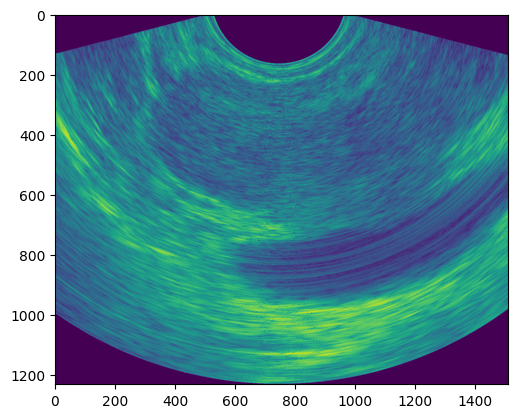

In [11]:
plt.imshow(img)

In [ ]:
# training resnet10 directly from windows



In [5]:
from einops import rearrange


loader = torch.utils.data.DataLoader(train_ds, batch_size=2, shuffle=True)
for batch in loader:
    bmode, needle_mask, grade = batch 
    bmode = bmode.cuda()
    needle_mask = needle_mask.cuda()
    grade = grade.cuda()

    B, C, H, W = bmode.shape 
    window_size = int(5 * H / 28), int(5 * W / 46)
    step_size = int(1 * H / 28), int(1 * W / 46)

    bmode = bmode.unfold(-2, window_size[0], step_size[0]).unfold(-2, window_size[1], step_size[1])
    B, C, Nh, Nw, H, W = bmode.shape
    bmode = rearrange(bmode, 'b c nh nw h w -> (b nh nw) c h w')
    bmode = torch.nn.functional.interpolate(bmode, (224, 224), mode='bilinear', align_corners=False)
    needle_mask = needle_mask.unfold(-2, window_size[0], step_size[0]).unfold(-2, window_size[1], step_size[1])
    needle_mask = needle_mask.mean((-1, -2))[:, 0, ...] > 0.65
    needle_mask = rearrange(needle_mask, 'b nh nw -> (b nh nw)')

    label = grade.repeat([1, Nh, Nw])
    label = rearrange(label, 'b nh nw -> (b nh nw)')[needle_mask]

    bmode = bmode[needle_mask]
    
    model(bmode)

    break

In [34]:
label.shape

torch.Size([80])

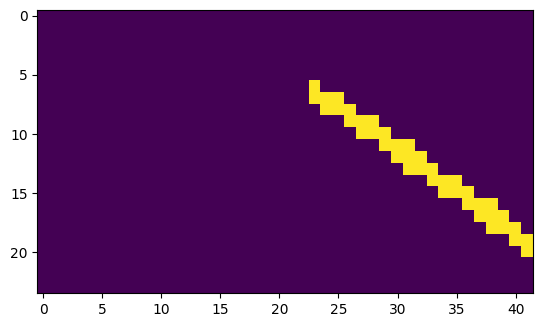

In [18]:
import matplotlib.pyplot as plt
plt.imshow(bmode[100, 0].cpu().numpy())
plt.imshow(needle_mask[0][0].cpu().numpy())

In [9]:
needle_mask

tensor([[[[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]]]], device='cuda:0')

In [5]:
bmode.shape

torch.Size([1, 3, 24, 42, 182, 111])

In [2]:
train_ds

In [34]:
class A: 
    def __init__(self, foo: str, bar: int): 
        self.foo = foo 
        self.bar = bar


def add_config(cls): 
    from dataclasses import dataclass


A.__init__.__code__

<code object __init__ at 0x7fb8f15773d0, file "/tmp/ipykernel_23662/758888923.py", line 2>